# Continuous Variables Through Regression Analysis

## Linear Regression

In [1]:
import pandas as pd

# Define the columns we want to load
columns = ['Overall Qual', 'Overall Cond', 'Gr Liv Area',
           'Central Air', 'Total Bsmt SF', 'SalePrice']

# Load Ames Housing dataset from URL
df = pd.read_csv(
    'http://jse.amstat.org/v19n3/decock/AmesHousing.txt',
    sep='\t',             # Tab-separated file
    usecols=columns       # Only load selected columns
)

# Preview first 5 rows of the dataframe
print(df.head())

   Overall Qual  Overall Cond  Total Bsmt SF Central Air  Gr Liv Area  \
0             6             5         1080.0           Y         1656   
1             5             6          882.0           Y          896   
2             6             6         1329.0           Y         1329   
3             7             5         2110.0           Y         2110   
4             5             5          928.0           Y         1629   

   SalePrice  
0     215000  
1     105000  
2     172000  
3     244000  
4     189900  


In [2]:
df.shape

(2930, 6)

In [3]:
df['Central Air'] = df['Central Air'].map({'N': 0, 'Y': 1})

In [4]:
df.isnull().sum()

Overall Qual     0
Overall Cond     0
Total Bsmt SF    1
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64

In [5]:
# remove the missing value
# Drop rows with missing values
df = df.dropna(axis=0)

# Check if any null values remain in the dataset
print(df.isnull().sum())

Overall Qual     0
Overall Cond     0
Total Bsmt SF    0
Central Air      0
Gr Liv Area      0
SalePrice        0
dtype: int64


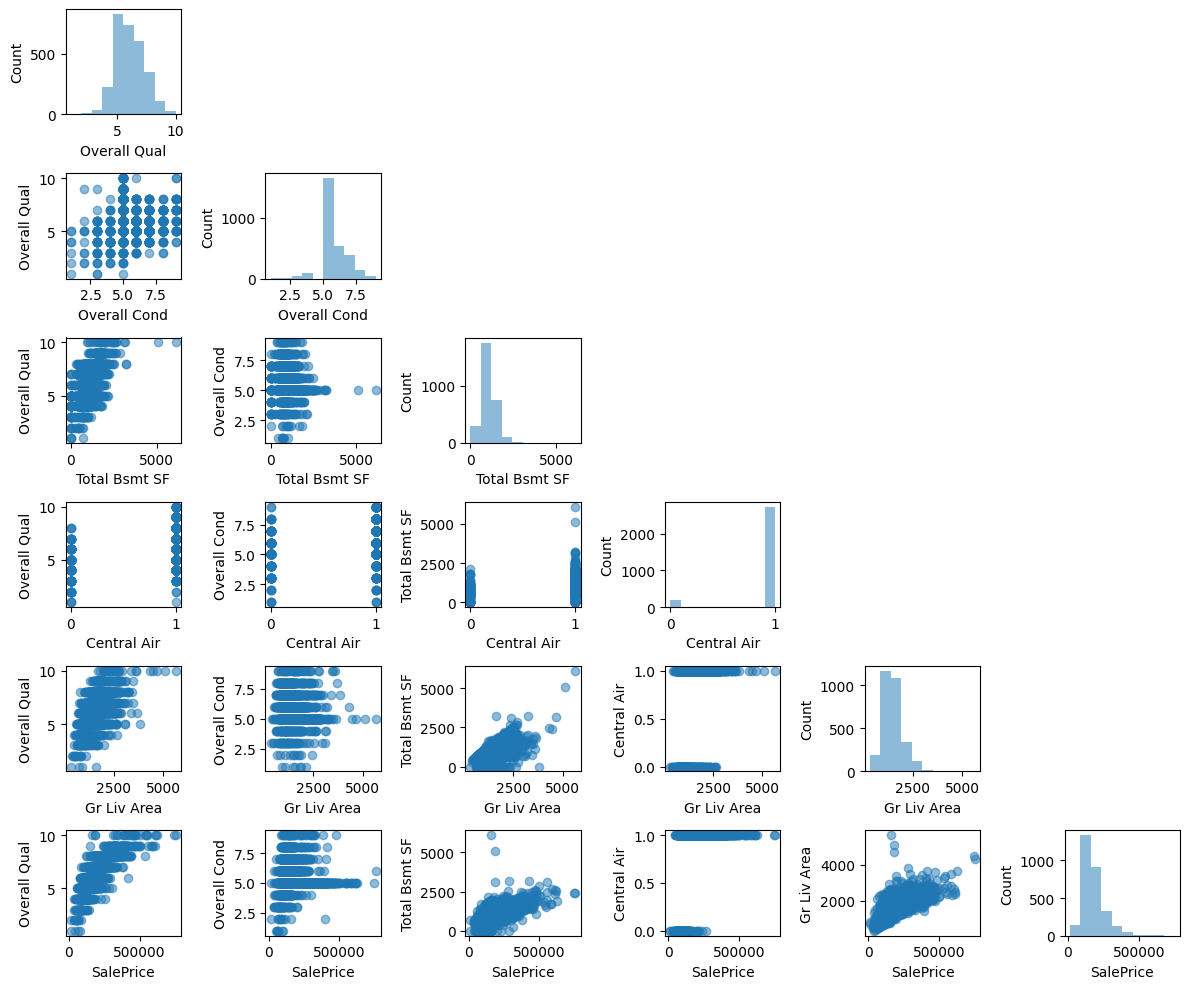

In [6]:
# Exploratory data analysis (EDA) is an important and recommended first step prior to training ML model. 
# First create a scatterplot matrix to visualize the pair-wise corrlations between different features
import matplotlib.pyplot as plt
from mlxtend.plotting import scatterplotmatrix # library that contains various convenience functions for ml and ds

# Create a scatterplot matrix of the DataFrame
scatterplotmatrix(df.values,
                  figsize=(12, 10),     # Figure size
                  names=df.columns,     # Column names for axes
                  alpha=0.5)            # Transparency for points

# Adjust spacing and show plot
plt.tight_layout()
plt.show() # There is somwhat linear relationship between size of living area above ground and sale price

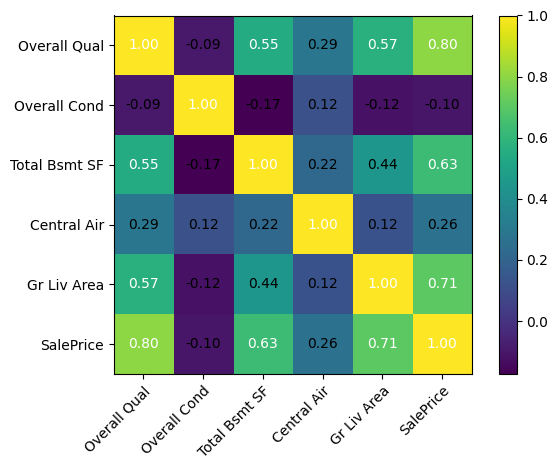

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import heatmap

# Compute the correlation matrix (transpose needed for features)
cm = np.corrcoef(df.values.T)

# Create a heatmap of correlations
hm = heatmap(cm,
             row_names=df.columns,    # Row labels
             column_names=df.columns) # Column labels

# Adjust spacing and show plot
plt.tight_layout()
plt.show() #salesprice shows the largest correlation with GR Liv Area variable with .71

### Solving regression for regression parameters with gradient descent

In [8]:
# Using the GD implementation of Adaline from chapter 2 nd removing the threshold function to implement first linear regression model
class LinearRegressionGD:
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
    def fit(self, X, y):
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.array([0.])
        self.losses_ = []
        for i in range(self.n_iter):
            output = self.net_input(X)
            errors = (y - output)
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self
    def net_input(self, X):
        return np.dot(X, self.w_) + self.b_
    def predict(self, X):
        return self.net_input(X)

In [9]:
# use the Gr Living Area freature to predict SalesPrice
import numpy as np
from sklearn.preprocessing import StandardScaler

# Extract features (living area) and target (sale price)
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

# Standardize the feature and target
sc_x = StandardScaler()
sc_y = StandardScaler()

X_std = sc_x.fit_transform(X)
y_std = sc_y.fit_transform(y[:, np.newaxis]).flatten()  # flatten target back to 1D

# Train linear regression model using gradient descent
lr = LinearRegressionGD(eta=0.1)  # assumes you defined LinearRegressionGD earlier
lr.fit(X_std, y_std)

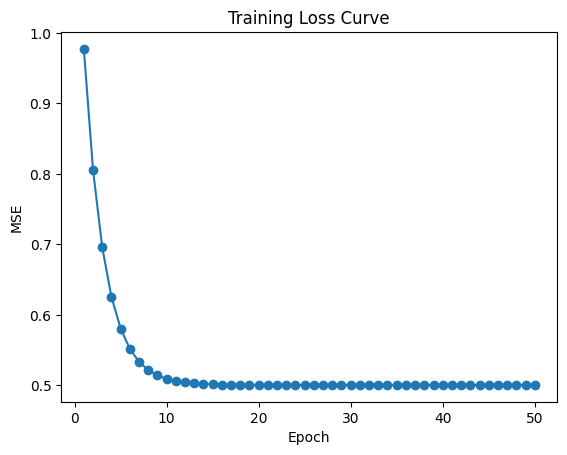

In [10]:
# Always a good idea to plot loss as a function of number of epochs over training dataset when using optimization algos like GD
import matplotlib.pyplot as plt

# Plot the Mean Squared Error (MSE) over epochs from gradient descent training
plt.plot(range(1, lr.n_iter + 1), lr.losses_, marker='o')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.title('Training Loss Curve')
plt.show()

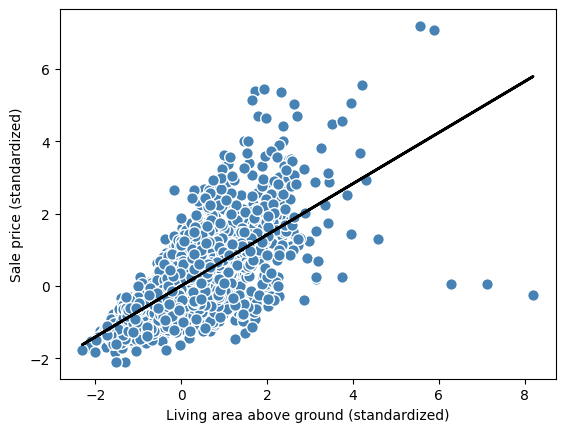

In [11]:
# Visualize how well linear regression line fits training data by creating helper function that will plot a scatter plot of training exampels and add regression line
def lin_regplot(X, y, model):
    # Scatter plot of feature values (X) vs target values (y)
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)

    # Plot regression line using model predictions
    plt.plot(X, model.predict(X), color='black', lw=2)
    
# use this function to plot living area against sales price
# Plot standardized living area vs. standardized sale price
lin_regplot(X_std, y_std, lr)

# Label axes
plt.xlabel('Living area above ground (standardized)')
plt.ylabel('Sale price (standardized)')

# Show the plot
plt.show() # while the observation makes sense, data does show that living area size does not explain house prices well in many cases. Later will discuss how to quantify performance of model
# We can also observe several outliers, which we will deal with later


In [12]:
# 

# Standardize a new living area value (2500 sq ft)
feature_std = sc_x.transform(np.array([[2500]]))

# Predict sale price using the trained linear regression model
target_std = lr.predict(feature_std)

# Convert prediction back to original scale (inverse transform)
target_reverted = sc_y.inverse_transform(target_std.reshape(-1, 1))

# Print the predicted sale price
print(f'Sales price: ${target_reverted.flatten()[0]:.2f}')

Sales price: $292507.07


In [13]:
# Print the slope (weight for the feature)
print(f"Slope: {lr.w_[0]:.3f}")

# Print the intercept (bias term)
print(f"Intercept: {lr.b_[0]:.3f}") # zero because we standardized the data


Slope: 0.707
Intercept: -0.000


In [14]:
# Estimating coefficient of regression model via scikit-learn
# Using sciki-learn's linear regression is more efficient and works better with unstandarzied data, so we can skip standardization step
from sklearn.linear_model import LinearRegression

# Create and fit the model
slr = LinearRegression()
slr.fit(X, y)

# Predict target values
y_pred = slr.predict(X)

# Print slope (coefficient for Gr Liv Area)
print(f"Slope: {slr.coef_[0]:.3f}")

# Print intercept (bias term)
print(f"Intercept: {slr.intercept_:.3f}")

Slope: 111.666
Intercept: 13342.979


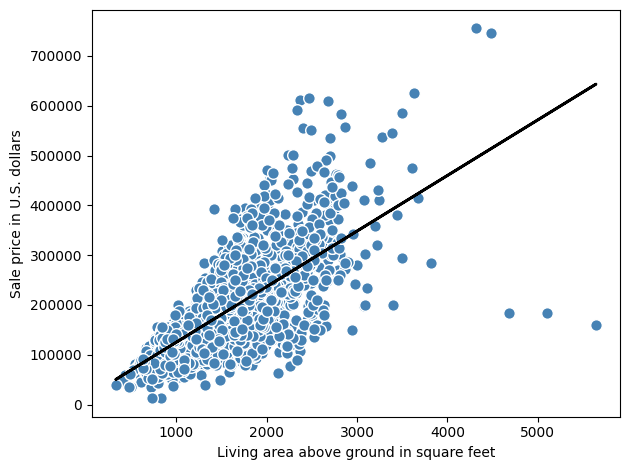

In [15]:
# Although slope and intercept are different, it still fits data similarly well:
# Plot regression line with actual data points
lin_regplot(X, y, slr)

# Add axis labels
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')

# Improve spacing/layout
plt.tight_layout()

# Show the plot
plt.show()

### Fitting robust regression model using RANSAC

In [16]:
from sklearn.linear_model import LinearRegression, RANSACRegressor

# Create a RANSAC regressor with a LinearRegression base model
ransac = RANSACRegressor(
    # base_estimator=LinearRegression(),  # underlying regression model
    estimator=LinearRegression(), # New version of scikitlearn changed it
    max_trials=100,                     # number of iterations # max number of iterations
    min_samples=0.95,                   # fraction of samples for each trial min number of randomly chosen examples have to be at least 95% of dataset
    residual_threshold=None,            # automatic threshold if None # automatically uses MAD (median absolute deviation)
    random_state=123                    # for reproducibility
)

# Fit RANSAC to the dataset
ransac.fit(X, y)

,estimator,LinearRegression()
,min_samples,0.95
,residual_threshold,None
,is_data_valid,None
,is_model_valid,None
,max_trials,100
,max_skips,inf
,stop_n_inliers,inf
,stop_score,inf
,stop_probability,0.99
,loss,'absolute_error'


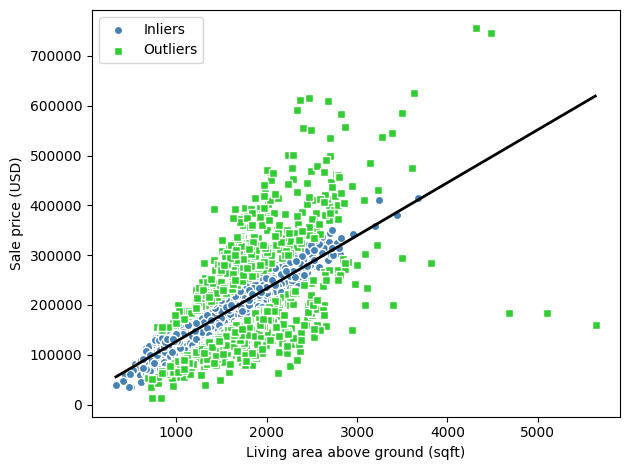

In [17]:
# Once fitted, now lets obtain inliers and outliers and plot them together with linear fit
# Get inliers and outliers
inlier_mask = ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

# Generate line for prediction (use full range of X)
line_X = np.arange(X.min(), X.max(), 10)  # step of 10 sqft for smoothness
line_y_ransac = ransac.predict(line_X[:, np.newaxis])

# Plot inliers
plt.scatter(X[inlier_mask], y[inlier_mask],
            c='steelblue', edgecolor='white',
            marker='o', label='Inliers')

# Plot outliers
plt.scatter(X[outlier_mask], y[outlier_mask],
            c='limegreen', edgecolor='white',
            marker='s', label='Outliers')

# Plot regression line
plt.plot(line_X, line_y_ransac, color='black', lw=2)

# Labels and legend
plt.xlabel('Living area above ground (sqft)')
plt.ylabel('Sale price (USD)')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
# slope and intercept slightly different
print(f"Slope: {ransac.estimator_.coef_[0]:.3f}")
print(f"Intercept: {ransac.estimator_.intercept_:.3f}")

Slope: 106.348
Intercept: 20190.093


In [19]:
def median_absolute_deviation(data):
    return np.median(np.abs(data - np.median(data)))

mad = median_absolute_deviation(y)
print(mad) # if we want to identify fewer data points as outliers, can choose residual threshold value greater than preceding MAD

37000.0


### Evaluating the performance of linear regression models

In [21]:
# Want to split dataset into train and test
# instead of simple regression model, we will now use all five features in dataset and train multiple regression model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Define target and features
target = 'SalePrice'
features = df.columns[df.columns != target]

# Separate features (X) and target (y)
X = df[features].values
y = df[target].values

# Split into training and test sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

# Create a linear regression model
slr = LinearRegression()

# Fit the model to the training data
slr.fit(X_train, y_train)

# Make predictions on train and test sets
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)

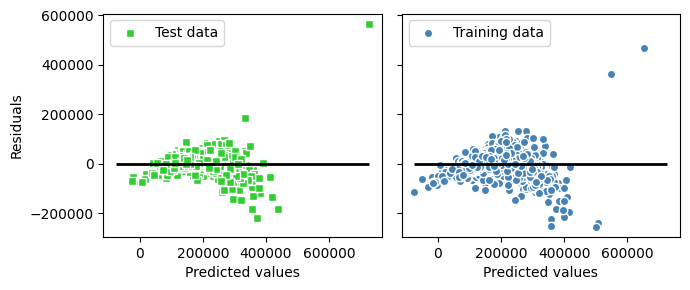

In [22]:
# since our model uses multiple explanatory variables, we can't visualize linear regression hyperplane, but we can plot residuals (difference or vertical distances between acutal and predicted values)
# Find the min and max predicted values (for axis scaling)
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

# Create two subplots: one for test data, one for training data
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

# Residuals for test data
ax1.scatter(
    y_test_pred, y_test_pred - y_test,
    c='limegreen', marker='s', edgecolor='white',
    label='Test data'
)

# Residuals for training data
ax2.scatter(
    y_train_pred, y_train_pred - y_train,
    c='steelblue', marker='o', edgecolor='white',
    label='Training data'
)

# Add labels
ax1.set_ylabel('Residuals')
for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    # Horizontal line at 0 residuals
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100,
              color='black', lw=2)

plt.tight_layout()
plt.show()

In [ ]:
# Getting MSE for sets
from sklearn.metrics import mean_squared_error
# Compute MSE for training and test sets
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f"MSE train: {mse_train:.2f}") # MSE on training is less than on test set, indicating overfitting
print(f"MSE test: {mse_test:.2f}")

MSE train: 1497216245.85
MSE test: 1516565821.00


In [ ]:
# Mean absolute error (MAE) emphasizes wrong predictions slightly less
from sklearn.metrics import mean_absolute_error

# Compute MAE for training and test sets
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)

print(f"MAE train: {mae_train:.2f}")
print(f"MAE test: {mae_test:.2f}")

MAE train: 25983.03
MAE test: 24921.29


In [ ]:
# Evaluating R^2 on our model
from sklearn.metrics import r2_score

# Compute R² for training and test sets
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"R² train: {train_r2:.3f}, R² test: {test_r2:.3f}") # model is only overfitting slightly # .77 isn't great but also isn't bad

R² train: 0.769, R² test: 0.752


### Using regularized methods for regression

In [27]:
from sklearn.linear_model import Ridge
ridge = Ridge(alpha=1.0)

In [28]:
from sklearn.linear_model import Lasso
lasso = Lasso(alpha=1.0)

In [29]:
from sklearn.linear_model import ElasticNet
elanet = ElasticNet(alpha=1.0, l1_ratio=0.5)

### Turning linear regression model into a curve - polynomial regression

#### Adding polynomial terms using scikit-learn

In [ ]:
# 1. Add second-degree polynomial term
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# Input feature (engine size, e.g.)
X = np.array([
    258.0, 270.0, 294.0, 320.0, 342.0,
    368.0, 396.0, 446.0, 480.0, 586.0
])[:, np.newaxis]  # reshape to 2D array for sklearn

# Target variable (e.g., CO2 emissions)
y = np.array([
    236.4, 234.4, 252.8, 298.6, 314.2,
    342.2, 360.8, 368.0, 391.2, 390.8
])

# Linear Regression model
lr = LinearRegression()

# Polynomial Regression model (will be applied on quadratic features)
pr = LinearRegression()

# Transform input X into quadratic features (x, x^2)
quadratic = PolynomialFeatures(degree=2)
X_quad = quadratic.fit_transform(X)

print("X_quad shape:", X_quad.shape)  # just to verify transformation

X_quad shape: (10, 3)


In [31]:
# 2. Fit simple linear regression model for comparison
# Fit the linear regression model on the original data
lr.fit(X, y)

# Generate a range of X values for plotting the regression line
X_fit = np.arange(250, 600, 10)[:, np.newaxis]  # 250, 260, ..., 590

# Predict target values using the fitted linear model
y_lin_fit = lr.predict(X_fit)

print("Predicted values (linear model) for X_fit:\n", y_lin_fit[:5], "...")  # show first 5 predictions


Predicted values (linear model) for X_fit:
 [250.86164718 256.26469105 261.66773493 267.0707788  272.47382268] ...


In [32]:
# Fit multiple regression model on transformed features for polynomial regression
# Fit the quadratic regression model on the transformed features
pr.fit(X_quad, y)

# Transform the X values to quadratic features and predict
y_quad_fit = pr.predict(quadratic.fit_transform(X_fit))

print("Predicted values (quadratic model) for X_fit:\n", y_quad_fit[:5], "...")  # show first 5 predictions


Predicted values (quadratic model) for X_fit:
 [215.86619864 228.37947485 240.44271083 252.0559066  263.21906215] ...


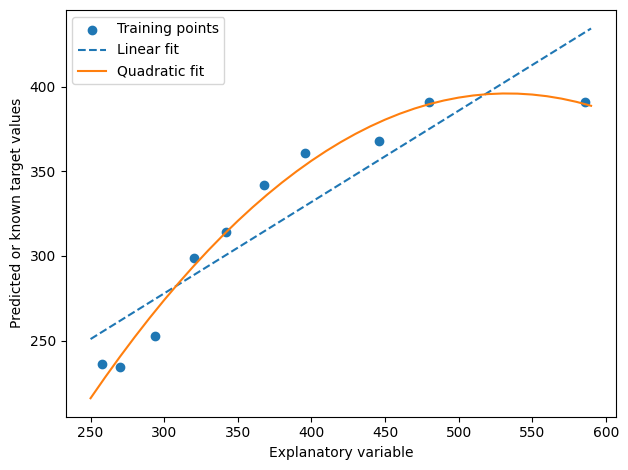

In [ ]:
# 4. Plot results
import matplotlib.pyplot as plt

# Plot the original data points
plt.scatter(X, y, label='Training points')

# Plot the linear regression fit (dashed line)
plt.plot(X_fit, y_lin_fit, label='Linear fit', linestyle='--')

# Plot the quadratic regression fit (solid line)
plt.plot(X_fit, y_quad_fit, label='Quadratic fit')

# Add axis labels
plt.xlabel('Explanatory variable')
plt.ylabel('Predicted or known target values')

# Add legend in the upper left
plt.legend(loc='upper left')

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show() # Can see that polynomial fit captures the relationship much better than the linear fit

In [ ]:
# Computer the MSE and R^2 for evaluation
from sklearn.metrics import mean_squared_error, r2_score

# Predict target values using the linear and quadratic models
y_lin_pred = lr.predict(X)
y_quad_pred = pr.predict(X_quad)

# Compute Mean Squared Error (MSE) for both models
mse_lin = mean_squared_error(y, y_lin_pred)
mse_quad = mean_squared_error(y, y_quad_pred)
print(f'Training MSE linear: {mse_lin:.3f}, quadratic: {mse_quad:.3f}')

# Compute R-squared (coefficient of determination) for both models
r2_lin = r2_score(y, y_lin_pred)
r2_quad = r2_score(y, y_quad_pred)
print(f'Training R^2 linear: {r2_lin:.3f}, quadratic: {r2_quad:.3f}') # Quadratic model has much better fit


Training MSE linear: 569.780, quadratic: 61.330
Training R^2 linear: 0.832, quadratic: 0.982


#### Modeling nonlinear relationships in the Ames Housing Dataset

In [35]:
# Have a more concrete example and use the Ames Housing Dataset
# Start by removing the 3 outliers
# Select the feature and target
X = df[['Gr Liv Area']].values  # Predictor: ground living area in square feet
y = df['SalePrice'].values      # Target: sale price in USD

# Remove outliers where 'Gr Liv Area' >= 4000
mask = df['Gr Liv Area'] < 4000
X = X[mask]
y = y[mask]

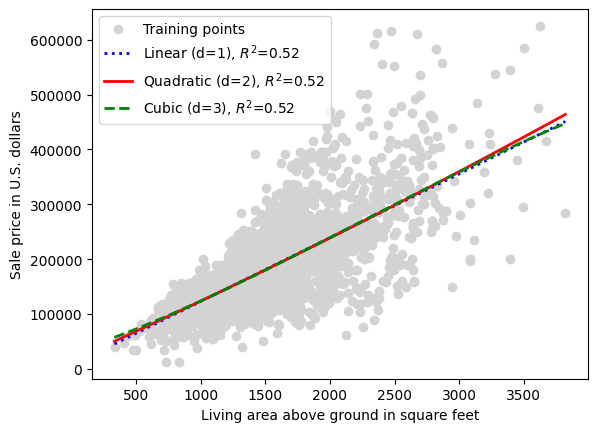

In [ ]:
# Now fit the regression model and plot results
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt

# Initialize linear regression model
regr = LinearRegression()

# Create quadratic and cubic polynomial features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# Create an array of values for plotting fitted curves
X_fit = np.arange(X.min() - 1, X.max() + 2, 1)[:, np.newaxis]

# Fit and predict using linear model
regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

# Fit and predict using quadratic model
regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

# Fit and predict using cubic model
regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# Plot training points and fitted regression curves
plt.scatter(X, y, label='Training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, 
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, 
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, 
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green', lw=2, linestyle='--')
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.show()
# Quadratic or cubic features does not really have an effect as the relationship appears to be linear

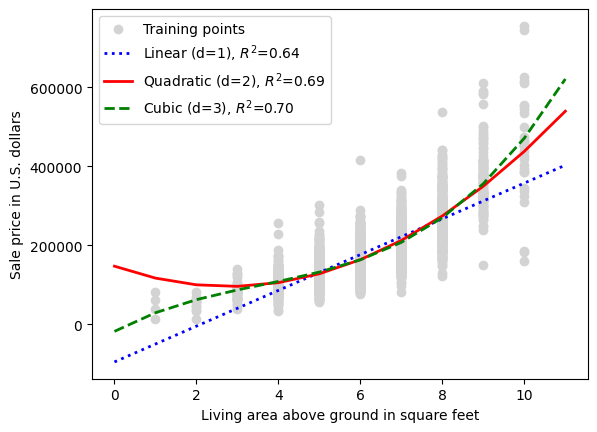

In [ ]:
# Lets look at another feature: Overall qual is quality of model and finish of house and is rating from 1 to 10
# Select a single feature 'Overall Qual' as predictor
X = df[['Overall Qual']].values  

# Target variable is 'SalePrice'
y = df['SalePrice'].values  

# Initialize linear regression model
regr = LinearRegression()

# Create quadratic and cubic polynomial features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# Create an array of values for plotting fitted curves
X_fit = np.arange(X.min() - 1, X.max() + 2, 1)[:, np.newaxis]

# Fit and predict using linear model
regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

# Fit and predict using quadratic model
regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

# Fit and predict using cubic model
regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

# Plot training points and fitted regression curves
plt.scatter(X, y, label='Training points', color='lightgray')
plt.plot(X_fit, y_lin_fit, 
         label=f'Linear (d=1), $R^2$={linear_r2:.2f}',
         color='blue', lw=2, linestyle=':')
plt.plot(X_fit, y_quad_fit, 
         label=f'Quadratic (d=2), $R^2$={quadratic_r2:.2f}',
         color='red', lw=2, linestyle='-')
plt.plot(X_fit, y_cubic_fit, 
         label=f'Cubic (d=3), $R^2$={cubic_r2:.2f}',
         color='green', lw=2, linestyle='--')
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.legend(loc='upper left')
plt.show() # Quadratic and cubic fit captures relationship much better than linear fit, but should be aware more polynomial features increases complexity of model
# Always recommended to evaluate performance of model on separate test dataset to ensure generalization

### Dealing with nonlinear relationships with random forests

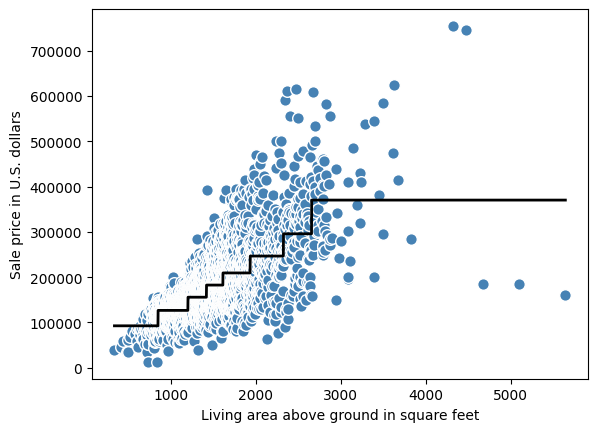

In [ ]:
# model relationship between sales price and gr living area, as they don't necessarily follow a linear pattern
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt

# Select feature and target
X = df[['Gr Liv Area']].values
y = df['SalePrice'].values

# Fit a decision tree regressor with max depth of 3
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

# Sort the feature values for plotting
sort_idx = X.flatten().argsort()

# Plot the predicted vs actual values using the custom plotting function
lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('Living area above ground in square feet')
plt.ylabel('Sale price in U.S. dollars')
plt.show()
# Decision tree captures general trend in data, but limitation is that it doesn't capture continuity and differentiability of desired prediction

In [ ]:
# Using random forest instead to reduce overfitting 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Define target and features
target = 'SalePrice'
features = df.columns[df.columns != target]

X = df[features].values
y = df[target].values

# Split dataset into training and test sets (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123
)

# Create a Random Forest regressor
forest = RandomForestRegressor(
    n_estimators=1000,          # Number of trees in the forest
    criterion='squared_error',  # Loss function for splitting
    random_state=1,             # For reproducibility
    n_jobs=-1                   # Use all CPU cores
)

# Fit model to training data
forest.fit(X_train, y_train)

# Predict on training and test sets
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

# Evaluate model performance
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f'MAE train: {mae_train:.2f}')
print(f'MAE test: {mae_test:.2f}')

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)
print(f'R^2 train: {r2_train:.2f}')
print(f'R^2 test: {r2_test:.2f}') 
# Still overfits the data but explains better than the linear model we had in the previous section


MAE train: 8305.18
MAE test: 20821.77
R^2 train: 0.98
R^2 test: 0.85


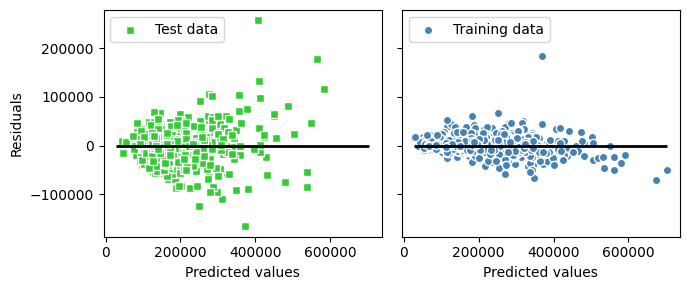

In [ ]:
# Look at the residuals
import matplotlib.pyplot as plt
import numpy as np

# Determine min and max of predicted values for plotting
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

# Create two subplots side by side for residual plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

# Plot residuals for the test data
ax1.scatter(
    y_test_pred, 
    y_test_pred - y_test, 
    c='limegreen', marker='s', edgecolor='white',
    label='Test data'
)

# Plot residuals for the training data
ax2.scatter(
    y_train_pred, 
    y_train_pred - y_train, 
    c='steelblue', marker='o', edgecolor='white',
    label='Training data'
)

ax1.set_ylabel('Residuals')

# Add horizontal line at 0 and labels
for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()
plt.show()
# Model fits training better than test, but is still large improvement over residual of linear model we plotted earlier
